In [7]:
# Install with retries and connection handling
!pip install --retries 10 --timeout 100 \
    tensorflow==2.16.2 \
    numpy==1.26.4 \
    pandas \
    scikit-learn \
    matplotlib

import tensorflow as tf
import numpy as np
print(f"TF: {tf.__version__}, NumPy: {np.__version__}")  # Verify TF 2.16.2 and NumPy 1.26.4

TF: 2.16.2, NumPy: 1.26.4


In [44]:
# Import these libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(f"TensorFlow: {tf.__version__}, NumPy: {np.__version__}")


TensorFlow: 2.16.2, NumPy: 1.26.4


In [15]:
# Data preparation

# Data Preparation (data_preparation.py)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
from pathlib import Path
import os


def prepare_data():
    # Create directories if they don't exist
    Path("../models").mkdir(parents=True, exist_ok=True)
    Path("../data/processed").mkdir(parents=True, exist_ok=True)
    Path("../reports/figures").mkdir(parents=True, exist_ok=True)

    # Load cleaned data
    df = pd.read_csv("../data/processed/cleaned_flood_data.csv")

    # Feature Engineering
    df["FLOOD_OCCURRENCE"] = (df["PERSONS_AFFECTED"] > 0).astype(int)  # Binary target
    df["DATE"] = pd.to_datetime(df["DATE"])
    df["DAY_OF_YEAR"] = df["DATE"].dt.dayofyear
    df["MONTH_SIN"] = np.sin(2 * np.pi * df["DATE"].dt.month / 12)  # Cyclical encoding
    df["MONTH_COS"] = np.cos(2 * np.pi * df["DATE"].dt.month / 12)

    # Define features and target
    numeric_features = ["DAY_OF_YEAR", "MONTH_SIN", "MONTH_COS"]
    categorical_features = ["STATE", "LGA", "SEASON"]  # Added SEASON as categorical

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            (
                "cat",
                OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                categorical_features,
            ),
        ],
        remainder="drop",  # Drop any columns not explicitly transformed
    )

    # Split data
    X = df[numeric_features + categorical_features]
    y = df["FLOOD_OCCURRENCE"].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit and transform the training data
    print("Fitting preprocessor...")
    X_train_preprocessed = preprocessor.fit_transform(X_train)

    # Transform test data
    X_test_preprocessed = preprocessor.transform(X_test)

    # Save preprocessing objects
    joblib.dump(preprocessor, "../models/preprocessor.joblib")
    print("✅ Preprocessor saved to ../models/preprocessor.joblib")

    # Get feature names after preprocessing
    numeric_feature_names = numeric_features
    categorical_feature_names = preprocessor.named_transformers_[
        "cat"
    ].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate(
        [numeric_feature_names, categorical_feature_names]
    )

    # For LSTM models - reshape into sequences (assuming 7-day sequences)
    def create_sequences(features, targets, sequence_length=7):
        X_seq, y_seq = [], []
        for i in range(len(features) - sequence_length):
            X_seq.append(features[i : i + sequence_length])
            y_seq.append(targets[i + sequence_length])
        return np.array(X_seq), np.array(y_seq)

    # Convert to sequences if using LSTM
    X_train_seq, y_train_seq = create_sequences(X_train_preprocessed, y_train)
    X_test_seq, y_test_seq = create_sequences(X_test_preprocessed, y_test)

    # Save processed data
    np.savez(
        "../data/processed/model_ready_data.npz",
        X_train=X_train_preprocessed,
        X_test=X_test_preprocessed,
        y_train=y_train,
        y_test=y_test,
        X_train_seq=X_train_seq,
        y_train_seq=y_train_seq,
        X_test_seq=X_test_seq,
        y_test_seq=y_test_seq,
        feature_names=all_feature_names,
    )

    print("✅ Data preparation complete!")
    print(
        f"Shapes - X_train: {X_train_preprocessed.shape}, X_test: {X_test_preprocessed.shape}"
    )
    print(
        f"Sequence shapes - X_train_seq: {X_train_seq.shape}, X_test_seq: {X_test_seq.shape}"
    )

    return {
        "preprocessor_path": "../models/preprocessor.joblib",
        "data_path": "../data/processed/model_ready_data.npz",
    }


if __name__ == "__main__":
    prepare_data()

Fitting preprocessor...
✅ Preprocessor saved to ../models/preprocessor.joblib
✅ Data preparation complete!
Shapes - X_train: (672, 280), X_test: (168, 280)
Sequence shapes - X_train_seq: (665, 7, 280), X_test_seq: (161, 7, 280)


In [7]:
# LSTM Model Implementation for Flood Prediction
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Setup directories
Path("../models").mkdir(exist_ok=True)
Path("../reports/figures").mkdir(exist_ok=True)

# Load data
data = np.load("../data/processed/model_ready_data.npz")
X_train, y_train = data["X_train_seq"], data["y_train_seq"]
X_test, y_test = data["X_test_seq"], data["y_test_seq"]


# LSTM Model
# Update model compilation:
def build_lstm(input_shape):
    model = Sequential(
        [
            LSTM(128, input_shape=input_shape, return_sequences=True),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(64, return_sequences=False),
            BatchNormalization(),
            Dropout(0.3),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(
        optimizer=Adam(0.001),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),  # Training precision
            tf.keras.metrics.Recall(name="recall"),  # Training recall
        ],
    )
    return model


# Train & evaluate
lstm = build_lstm((X_train.shape[1], X_train.shape[2]))
history = lstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint("../models/lstm_best.keras", save_best_only=True),
    ],
)

# Compute metrics manually (since val_precision/val_recall won't be auto-tracked)
from sklearn.metrics import precision_score, recall_score

y_pred = (lstm.predict(X_test) > 0.5).astype(int)
metrics = {
    "accuracy": history.history["val_accuracy"][-1],
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
}
joblib.dump(metrics, "../models/lstm_metrics.joblib")

# Plot training
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("LSTM Training History")
plt.savefig("../reports/figures/lstm_history.png")
plt.close()

/Users/raheeminioluwa/Documents/Flood-EDA-Nigeria/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.0040 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0062 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0063 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0062 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.0043 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0062 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.0037 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0062 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0033 - loss: nan - precision: 0.0000e+00 - recall: 0.0000

/Users/raheeminioluwa/Documents/Flood-EDA-Nigeria/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# CNN Model Implementation for Flood Prediction
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

# Load data
data = np.load("../data/processed/model_ready_data.npz")
X_train, y_train = data["X_train_seq"], data["y_train_seq"]
X_test, y_test = data["X_test_seq"], data["y_test_seq"]


# CNN Model
def build_cnn(input_shape):
    model = Sequential(
        [
            Conv1D(
                64, 2, activation="relu", input_shape=input_shape, padding="same"
            ),  # kernel_size=2
            BatchNormalization(),
            MaxPooling1D(2),
            Dropout(0.3),
            Conv1D(128, 2, activation="relu", padding="same"),  # kernel_size=2
            BatchNormalization(),
            MaxPooling1D(2),
            Dropout(0.3),
            Flatten(),
            Dense(64, activation="relu"),
            Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        optimizer=Adam(0.001),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),  # Training precision
            tf.keras.metrics.Recall(name="recall"),  # Training recall
        ],
    )
    return model


# Train
cnn = build_cnn((X_train.shape[1], X_train.shape[2]))
history = cnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=10),
        ModelCheckpoint("../models/cnn_best.keras", save_best_only=True)
    ]
)

# Save
cnn.save("../models/cnn_final.keras")
metrics = {
    "accuracy": history.history["val_accuracy"][-1],
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
}
joblib.dump(metrics, "../models/cnn_metrics.joblib")

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.0058 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0062 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0067 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0062 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0018 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0062 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0052 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0062 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0025 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+

/Users/raheeminioluwa/Documents/Flood-EDA-Nigeria/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['../models/cnn_metrics.joblib']

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    LSTM,
    Dense,
    TimeDistributed,
    Flatten,
)
from tensorflow.keras.models import Model
import numpy as np
import joblib

# Load data
data = np.load("../data/processed/model_ready_data.npz")
X_train = data["X_train_seq"].reshape(*data["X_train_seq"].shape, 1)
y_train = data["y_train_seq"]
X_test = data["X_test_seq"].reshape(*data["X_test_seq"].shape, 1)
y_test = data["y_test_seq"]


# Hybrid Model
def build_hybrid(input_shape):
    inputs = Input(input_shape)

    # CNN Branch
    x = TimeDistributed(Conv1D(64, 3, activation="relu"))(inputs)
    x = TimeDistributed(MaxPooling1D(2))(x)
    x = TimeDistributed(Flatten())(x)

    # LSTM Branch
    x = LSTM(64)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Train
hybrid = build_hybrid((X_train.shape[1], X_train.shape[2], 1))
hybrid.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=7, batch_size=32)

hybrid.save("../models/hybrid_final.keras")

Epoch 1/7
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 796ms/step - accuracy: 0.0315 - loss: nan - val_accuracy: 0.0062 - val_loss: nan
Epoch 2/7
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 507ms/step - accuracy: 0.0015 - loss: nan - val_accuracy: 0.0062 - val_loss: nan
Epoch 3/7
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - accuracy: 0.0039 - loss: nan - val_accuracy: 0.0062 - val_loss: nan
Epoch 4/7
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - accuracy: 0.0014 - loss: nan - val_accuracy: 0.0062 - val_loss: nan
Epoch 5/7
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 722ms/step - accuracy: 0.0057 - loss: nan - val_accuracy: 0.0062 - val_loss: nan
Epoch 6/7
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 538ms/step - accuracy: 0.0090 - loss: nan - val_accuracy: 0.0062 - val_loss: nan
Epoch 7/7
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 509ms/step - accuracy: 0.0034 - loss: nan - val_accuracy: 0.0062 - val_loss: nan


Model Performance Comparison:
      accuracy  precision  recall
LSTM  0.006211        0.0     0.0
CNN   0.006211        0.0     0.0


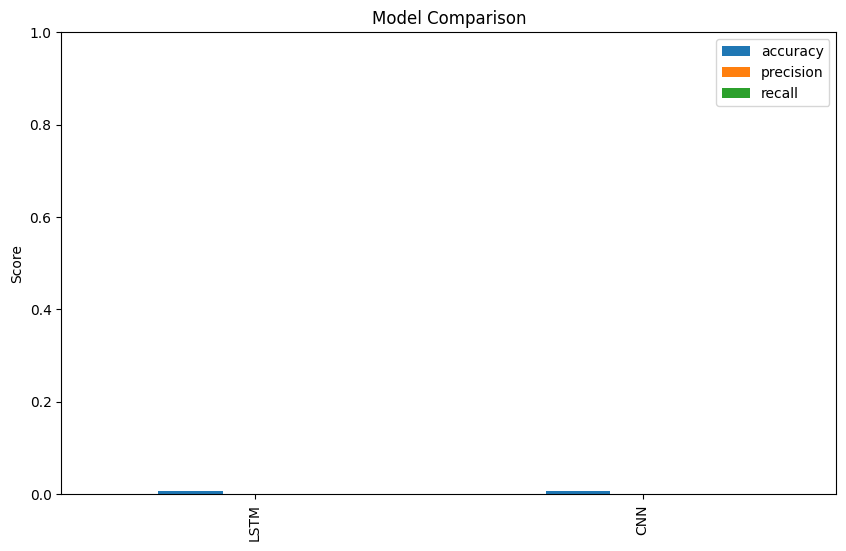

In [14]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load metrics
metrics = {
    "LSTM": joblib.load("../models/lstm_metrics.joblib"),
    "CNN": joblib.load("../models/cnn_metrics.joblib"),
    # "Hybrid": joblib.load("../models/hybrid_metrics.joblib"),
}

# Create comparison table
df = pd.DataFrame(metrics).T
print("Model Performance Comparison:")
print(df)

# Plot comparison
df.plot(kind="bar", figsize=(10, 6))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.savefig("../reports/figures/model_comparison.png")